<a href="https://colab.research.google.com/github/g-k-2410/environment/blob/main/GreenwashDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy spacy-transformers lime streamlit
!python -m spacy download en_core_web_sm


In [ ]:
!pip install openpyxl


In [ ]:
import pandas as pd

# Load Excel file
df = pd.read_csv("/content/train.csv")  # replace with your filename

df.head()


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
import pandas as pd

# Load your Excel file
df = pd.read_csv("/content/train.csv")  # change filename as needed

# Keep only useful columns
df = df[["Class Index", "Description"]].rename(columns={"Class Index": "label", "Description": "text"})
df.head()


,label,text
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
label_map = {
    1: "GREENWASH",   # Business
    2: "GENUINE",     # Sci/Tech
    3: "NEUTRAL",     # World
    4: "NEUTRAL"      # Sports → Neutral
}

df["label"] = df["label"].map(label_map)
df.head()


,label,text
0,NEUTRAL,"Reuters - Short-sellers, Wall Street's dwindli..."
1,NEUTRAL,Reuters - Private investment firm Carlyle Grou...
2,NEUTRAL,Reuters - Soaring crude prices plus worries\ab...
3,NEUTRAL,Reuters - Authorities have halted oil export\f...
4,NEUTRAL,"AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
df = df.sample(5000, random_state=42)  # keep it light for Colab


In [ ]:
df.head(1)

,label,text
71787,NEUTRAL,"London - The British Broadcasting Corporation,..."


In [ ]:
import spacy
from spacy.training.example import Example

# Initialize a blank English pipeline
nlp = spacy.blank("en")

# Add a text classifier (exclusive classes since we mapped into one label each)
textcat = nlp.add_pipe("textcat_multilabel", config={"exclusive_classes": True})

# Add labels from the dataframe
labels = df["label"].unique().tolist()
for label in labels:
    textcat.add_label(label)

# Build training examples
train_data = []
for _, row in df.iterrows():
    cats = {l: 0.0 for l in labels}
    cats[row["label"]] = 1.0
    doc = nlp.make_doc(row["text"])
    train_data.append(Example.from_dict(doc, {"cats": cats}))

print(f"Prepared {len(train_data)} training examples")


In [ ]:
import pandas as pd

# Load train and test CSVs
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# Keep only Class Index + Description
train_df = train_df[["Class Index", "Description"]].rename(columns={"Class Index": "label", "Description": "text"})
test_df = test_df[["Class Index", "Description"]].rename(columns={"Class Index": "label", "Description": "text"})


In [ ]:
label_map = {
    1: "GREENWASH",   # Business
    2: "GENUINE",     # Sci/Tech
    3: "NEUTRAL",     # World
    4: "NEUTRAL"      # Sports merged with Neutral
}

train_df["label"] = train_df["label"].map(label_map)
test_df["label"] = test_df["label"].map(label_map)


In [ ]:
# For multi-class classification (one label per text)
textcat = nlp.add_pipe("textcat", last=True)

# If you wanted multilabel (multiple labels per text), you’d use:
# textcat = nlp.add_pipe("textcat_multilabel", last=True)


In [ ]:
from spacy.training.example import Example

train_examples = []
for _, row in train_df.iterrows():
    cats = {l: 0.0 for l in labels}
    cats[row["label"]] = 1.0
    doc = nlp.make_doc(row["text"])
    train_examples.append(Example.from_dict(doc, {"cats": cats}))

print(f"Prepared {len(train_examples)} training examples")


Prepared 120000 training examples


In [ ]:
import random
from spacy.util import minibatch

optimizer = nlp.initialize()

for epoch in range(5):   # can increase if Colab runtime allows
    random.shuffle(train_examples)
    losses = {}
    for batch in minibatch(train_examples, size=8):
        nlp.update(batch, sgd=optimizer, drop=0.2, losses=losses)
    print(f"Epoch {epoch+1} - Losses: {losses}")


Epoch 1 - Losses: {'textcat': 734.8583267910695}
Epoch 2 - Losses: {'textcat': 540.9983627498025}
Epoch 3 - Losses: {'textcat': 486.66728329416105}
Epoch 4 - Losses: {'textcat': 451.19278776053153}
Epoch 5 - Losses: {'textcat': 427.8466270960851}


In [21]:
correct = 0
total = 0

for _, row in test_df.iterrows():
    doc = nlp(row["text"])
    pred_label = max(doc.cats, key=doc.cats.get)  # label with highest score
    if pred_label == row["label"]:
        correct += 1
    total += 1

print("Accuracy:", correct / total)


Accuracy: 0.9406578947368421


In [22]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for _, row in test_df.iterrows():
    doc = nlp(row["text"])
    pred_label = max(doc.cats, key=doc.cats.get)
    y_true.append(row["label"])
    y_pred.append(pred_label)

print(classification_report(y_true, y_pred, target_names=labels))


              precision    recall  f1-score   support

     NEUTRAL       0.95      0.96      0.96      1900
     GENUINE       0.89      0.92      0.90      1900
   GREENWASH       0.96      0.94      0.95      3800

    accuracy                           0.94      7600
   macro avg       0.93      0.94      0.94      7600
weighted avg       0.94      0.94      0.94      7600



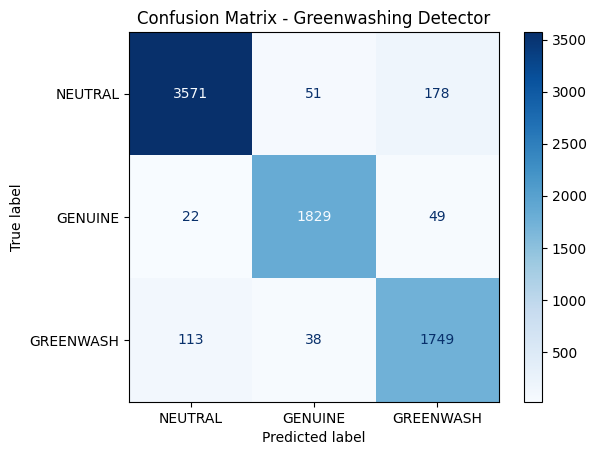

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Collect predictions vs truth
y_true = []
y_pred = []

for _, row in test_df.iterrows():
    doc = nlp(row["text"])
    pred_label = max(doc.cats, key=doc.cats.get)
    y_true.append(row["label"])
    y_pred.append(pred_label)

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Greenwashing Detector")
plt.show()
